In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras import Model
from keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2024-03-04 14:03:33.536731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 14:03:33.536768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 14:03:33.537486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 14:03:33.542510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 14:03:34.108106: W tensorflow/compiler/tf2

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../SmartBin/data/raw_data/Garbage_classification_dataset"
walk_through_dir(dataset)
data_dir = Path(dataset)

There are 6 directories and 0 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset'.
There are 0 directories and 1090 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Papier_Carton'.
There are 0 directories and 1064 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Brique_en_carton'.
There are 0 directories and 1060 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Ordure_mn++nagn++re'.
There are 0 directories and 1260 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Verre'.
There are 0 directories and 1240 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Emballage_metallique'.
There are 0 directories and 1474 images in '../../SmartBin/data/raw_data/Garbage_classification_dataset/Bouteille_plastique'.


In [5]:
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

[3349 5890  911 6062 6220 5070  180 1625 3682 2042 2712 5343 4428 6553
 7125 5486]


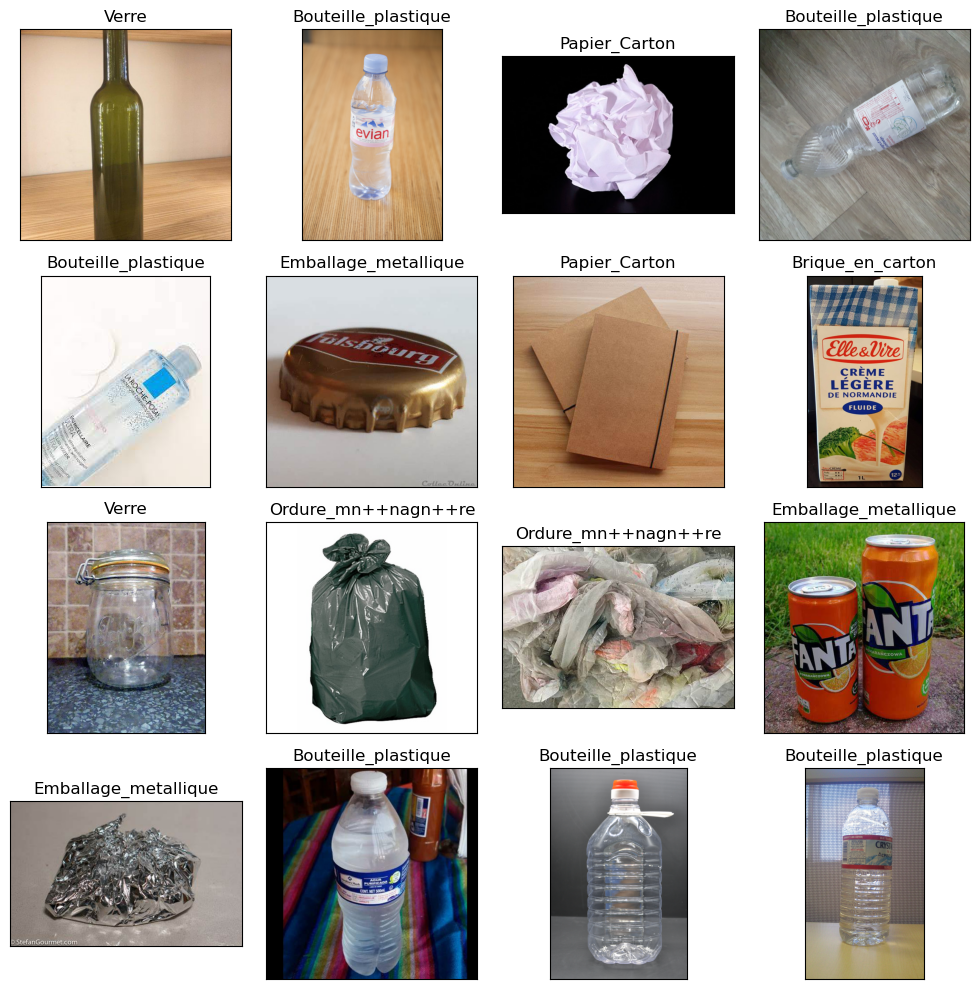

In [6]:
image_df = pd.concat([filepaths, labels], axis=1)
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape
test_df.shape

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [8]:
batch_size = 32
img_size = (200, 200)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 4564 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.
Found 1426 validated image filenames belonging to 6 classes.


In [9]:
print(train_images.classes[0:10])

[0, 3, 0, 3, 3, 1, 3, 2, 4, 3]


In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

2024-03-04 14:03:37.118408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 14:03:37.118606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 14:03:37.140315: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

58889256/58889256 [==============================] - 5s 0us/step


In [11]:
inputs = pretrained_model.inputs
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(6, activation='softmax')(x)
model = Model(inputs, outputs)

In [12]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
# # Create checkpoint callback
# checkpoint_path = "bags_classification_model_checkpoint"
# checkpoint_callback = ModelCheckpoint(checkpoint_path,
#                                       save_weights_only=True,
#                                       monitor="val_accuracy",
#                                       save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=20)

In [ ]:
# Train the model
history = model.fit(train_images,
                    steps_per_epoch=len(train_images),
                    epochs=20,
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stopping_callback])

Epoch 1/20


/opt/tljh/user/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


143/143 [==============================] - 334s 2s/step - loss: 1.8575 - accuracy: 0.5486 - val_loss: 0.3387 - val_accuracy: 0.8825
Epoch 2/20
143/143 [==============================] - 333s 2s/step - loss: 0.5810 - accuracy: 0.8162 - val_loss: 0.2171 - val_accuracy: 0.9237
Epoch 3/20
143/143 [==============================] - 333s 2s/step - loss: 0.3715 - accuracy: 0.8821 - val_loss: 0.1674 - val_accuracy: 0.9447
Epoch 4/20
143/143 [==============================] - 333s 2s/step - loss: 0.2806 - accuracy: 0.9097 - val_loss: 0.1511 - val_accuracy: 0.9535
Epoch 5/20
143/143 [==============================] - 333s 2s/step - loss: 0.2170 - accuracy: 0.9270 - val_loss: 0.1414 - val_accuracy: 0.9553


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 12 predictions: {pred[:12]}')

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()